# Load the required libraries

In [2]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# U-Net architecture

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


In [6]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return p

In [15]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels, out_channels)

    def forward(self, x1):
        x1 = self.up(x1)
        return self.conv(x1)

In [16]:
class UNetSinConexiones(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)

        self.bottle_neck = DoubleConv(256, 512)

        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        p1 = self.down_convolution_1(x)
        p2 = self.down_convolution_2(p1)
        p3 = self.down_convolution_3(p2)

        b = self.bottle_neck(p3)

        up_2 = self.up_convolution_2(b)
        up_3 = self.up_convolution_3(up_2)
        up_4 = self.up_convolution_4(up_3)

        out = self.out(up_4)
        return out


In [17]:
input_image = torch.rand((1,3,128,128))
model = UNetSinConexiones(3,10)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 10, 512, 512]) as a result

torch.Size([1, 10, 128, 128])


# Load the Carvana Dataset

In [18]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train/")])[:self.limit]
        self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask), self.images[index]

    def __len__(self):
        
        return min(len(self.images), self.limit)

In [19]:

print(os.listdir("caravana/train/"))

DATASET_DIR = 'caravana/'
WORKING_DIR = '.'

['bd8d5780ed04_07.jpg', '6752de44b721_01.jpg', '1390696b70b6_02.jpg', 'ce74dfdf123b_04.jpg', 'ce74dfdf123b_10.jpg', '1390696b70b6_16.jpg', '6752de44b721_15.jpg', '292f59c6a347_03.jpg', 'bd8d5780ed04_13.jpg', '8d5423cb763c_13.jpg', '898339fab87a_05.jpg', '7251c8797749_10.jpg', '7ac210ba75a1_01.jpg', '917f262f1608_10.jpg', '11fcda0a9e1c_08.jpg', '858841907a4a_16.jpg', '2f39abb12388_08.jpg', 'acb0fd30b83d_13.jpg', 'e5fc2c1c4a8b_12.jpg', 'b24fd9084449_03.jpg', 'acb0fd30b83d_07.jpg', 'e5fc2c1c4a8b_06.jpg', '917f262f1608_04.jpg', '858841907a4a_02.jpg', '7ac210ba75a1_15.jpg', '8d5423cb763c_07.jpg', '898339fab87a_11.jpg', '7251c8797749_04.jpg', '0d1a9caf4350_12.jpg', '42d81612e2ce_07.jpg', '9dfaeb835626_11.jpg', 'c3dafdb02e7f_02.jpg', '3a7a8f03e713_02.jpg', '6f6dced498c4_05.jpg', '1e6f48393e17_03.jpg', '65051cfe0789_09.jpg', 'eefc0d8c94f0_08.jpg', 'c3dafdb02e7f_16.jpg', '3a7a8f03e713_16.jpg', '6f6dced498c4_11.jpg', '42d81612e2ce_13.jpg', '9dfaeb835626_05.jpg', '2cb91c2543fa_09.jpg', '0d1a9caf4

In [20]:
train_dataset = CarvanaDataset(DATASET_DIR, limit=2000)

generator = torch.Generator().manual_seed(25)

In [21]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

In [22]:
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [23]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [24]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 5
out_checkpoint = 'my_checkpoint_small_2.pth'

In [26]:
train_dataloader = DataLoader(dataset=train_dataset,
                              pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNetSinConexiones(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Running the experiment

In [27]:

def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [28]:
torch.mps.empty_cache()

In [29]:
EPOCHS = 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Guardar el modelo
torch.save(model.state_dict(), out_checkpoint)


 10%|█         | 1/10 [00:35<05:15, 35.02s/it]

------------------------------
Training Loss EPOCH 1: 0.1838
Training DICE EPOCH 1: 0.7248


Validation Loss EPOCH 1: 0.0792
Validation DICE EPOCH 1: 0.9272
------------------------------


 20%|██        | 2/10 [01:09<04:37, 34.67s/it]

------------------------------
Training Loss EPOCH 2: 0.0520
Training DICE EPOCH 2: 0.9489


Validation Loss EPOCH 2: 0.0374
Validation DICE EPOCH 2: 0.9647
------------------------------


 30%|███       | 3/10 [01:44<04:02, 34.63s/it]

------------------------------
Training Loss EPOCH 3: 0.0338
Training DICE EPOCH 3: 0.9664


Validation Loss EPOCH 3: 0.0404
Validation DICE EPOCH 3: 0.9634
------------------------------


 40%|████      | 4/10 [02:17<03:25, 34.28s/it]

------------------------------
Training Loss EPOCH 4: 0.0280
Training DICE EPOCH 4: 0.9722


Validation Loss EPOCH 4: 0.0271
Validation DICE EPOCH 4: 0.9741
------------------------------


 50%|█████     | 5/10 [02:51<02:49, 33.97s/it]

------------------------------
Training Loss EPOCH 5: 0.0251
Training DICE EPOCH 5: 0.9750


Validation Loss EPOCH 5: 0.0269
Validation DICE EPOCH 5: 0.9747
------------------------------


 60%|██████    | 6/10 [03:24<02:15, 33.76s/it]

------------------------------
Training Loss EPOCH 6: 0.0229
Training DICE EPOCH 6: 0.9772


Validation Loss EPOCH 6: 0.0238
Validation DICE EPOCH 6: 0.9775
------------------------------


 70%|███████   | 7/10 [03:57<01:40, 33.61s/it]

------------------------------
Training Loss EPOCH 7: 0.0212
Training DICE EPOCH 7: 0.9788


Validation Loss EPOCH 7: 0.0228
Validation DICE EPOCH 7: 0.9782
------------------------------


 80%|████████  | 8/10 [04:41<01:13, 36.90s/it]

------------------------------
Training Loss EPOCH 8: 0.0207
Training DICE EPOCH 8: 0.9793


Validation Loss EPOCH 8: 0.0230
Validation DICE EPOCH 8: 0.9776
------------------------------


 90%|█████████ | 9/10 [05:15<00:35, 35.95s/it]

------------------------------
Training Loss EPOCH 9: 0.0201
Training DICE EPOCH 9: 0.9799


Validation Loss EPOCH 9: 0.0210
Validation DICE EPOCH 9: 0.9799
------------------------------


100%|██████████| 10/10 [05:49<00:00, 34.96s/it]


------------------------------
Training Loss EPOCH 10: 0.0189
Training DICE EPOCH 10: 0.9810


Validation Loss EPOCH 10: 0.0200
Validation DICE EPOCH 10: 0.9808
------------------------------


# Results

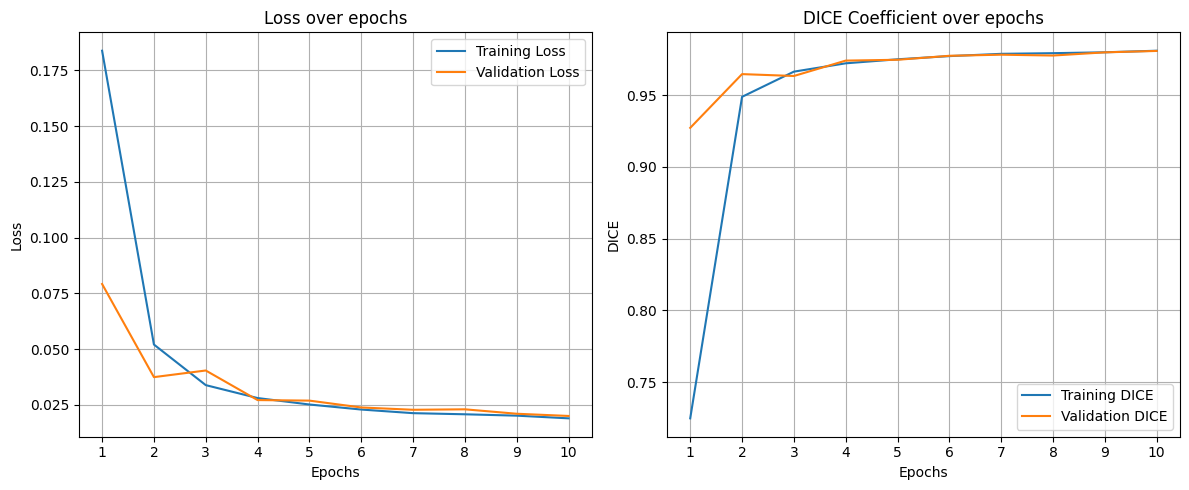

In [30]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


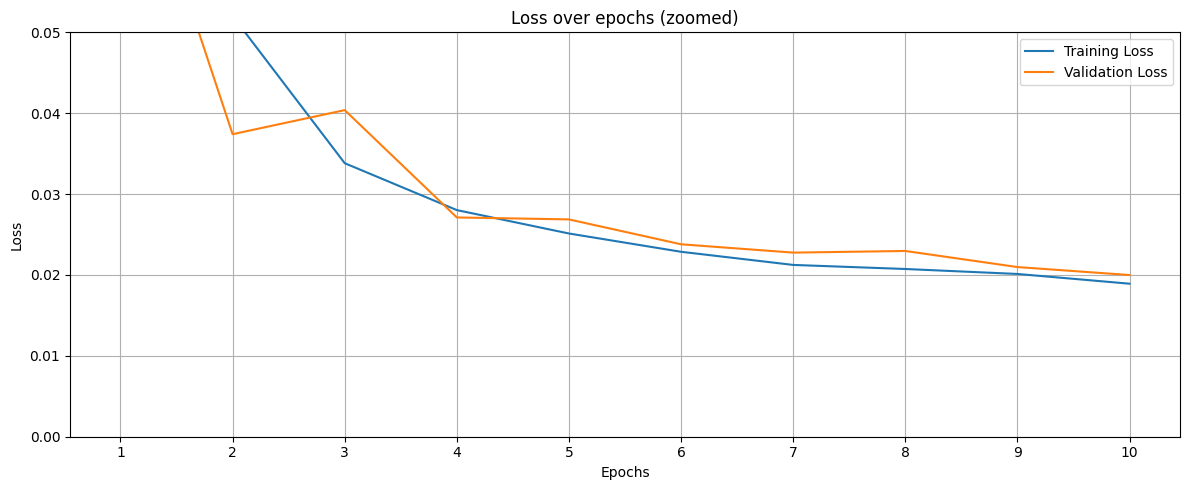

In [31]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.ylim(0, 0.05)
plt.title('Loss over epochs (zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()



In [33]:
model_pth = out_checkpoint
trained_model = UNetSinConexiones(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_59695/2346751658.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(mode

<All keys matched successfully>

In [34]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)


100%|██████████| 40/40 [00:01<00:00, 28.11it/s]


In [35]:
test_loss

0.018697147094644605

In [36]:
test_dc

0.981043341755867

In [41]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device, flip=False):
    model = UNetSinConexiones(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    if flip:
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(p=1.0)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((128, 128))
        ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        
        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()


In [42]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 



/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_59695/3993457196.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, m

Image: 34b0c08544a5_03.jpg, DICE coefficient: 0.9829


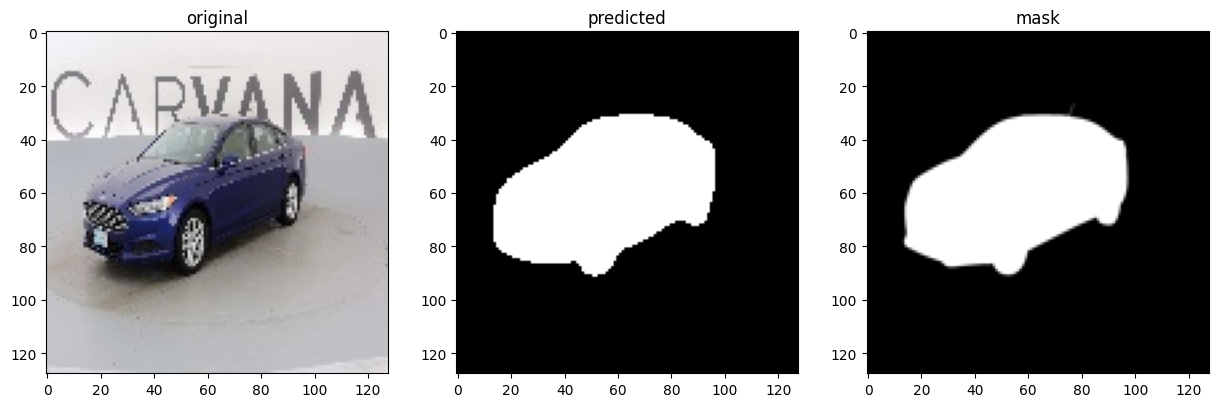

Image: 11f3dc041cfb_10.jpg, DICE coefficient: 0.98336


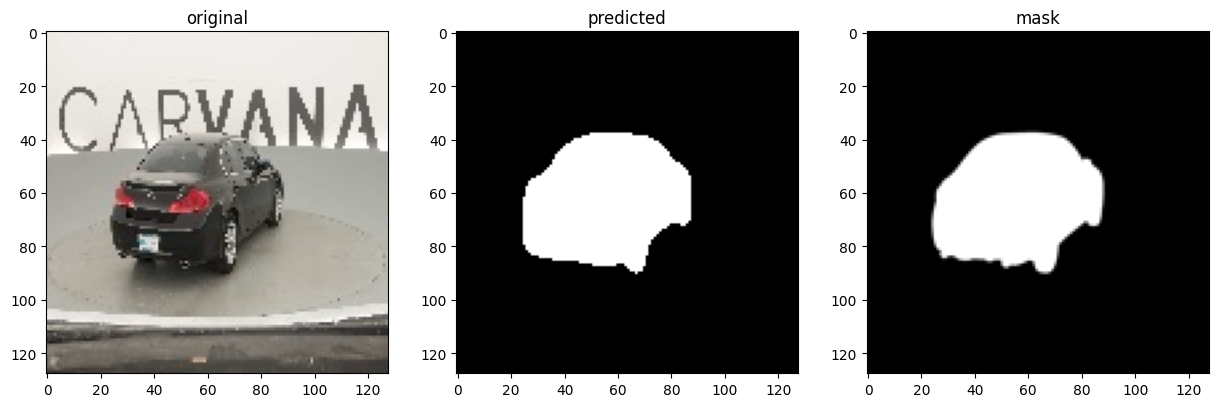

Image: 3c54e71fd2c9_02.jpg, DICE coefficient: 0.98269


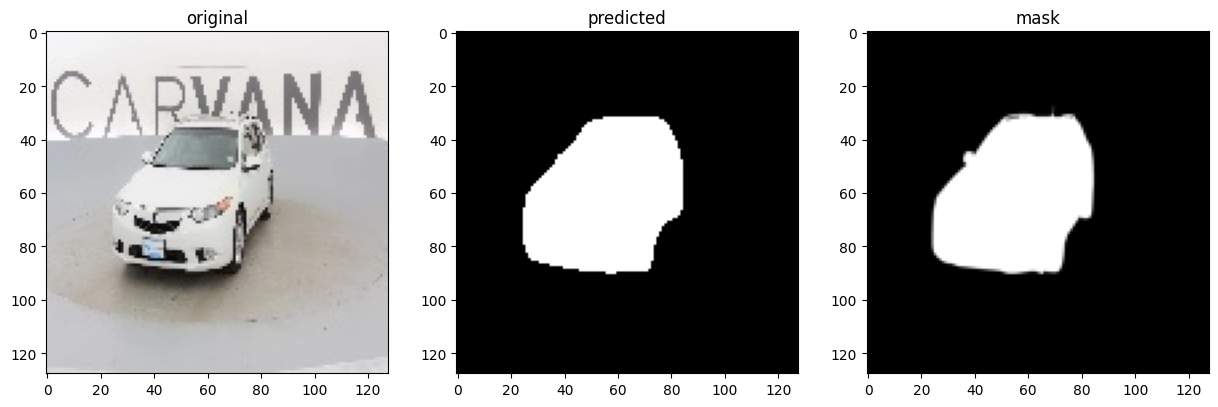

Image: 2cb91c2543fa_11.jpg, DICE coefficient: 0.98361


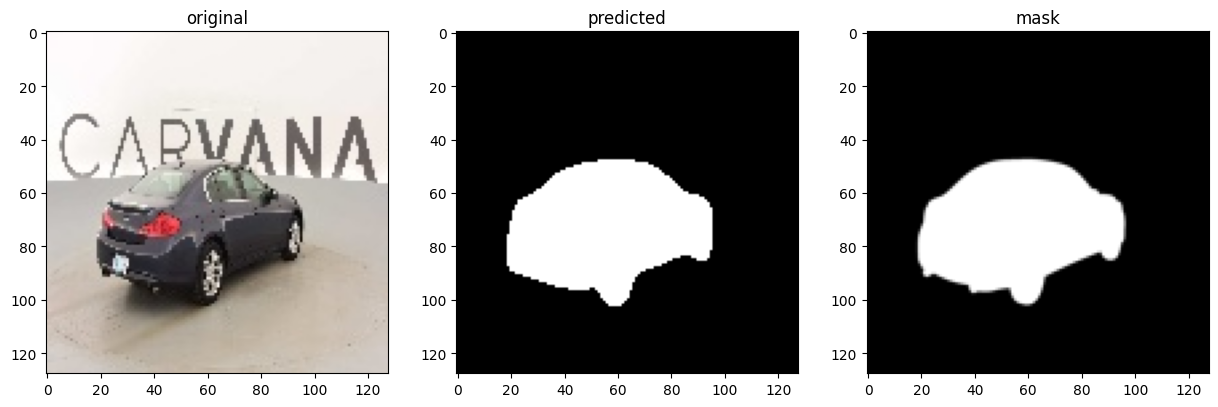

Image: 3810c5e1cdeb_15.jpg, DICE coefficient: 0.98241


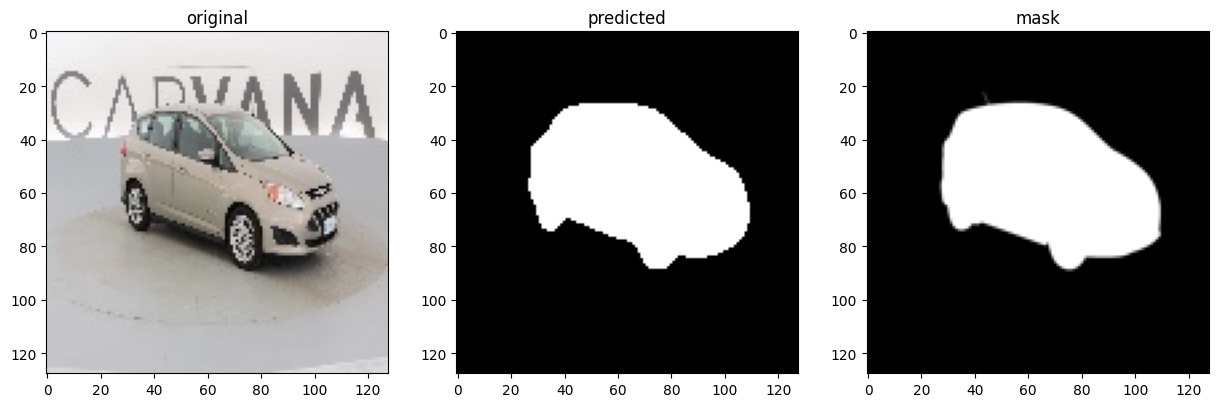

Image: 02159e548029_15.jpg, DICE coefficient: 0.98427


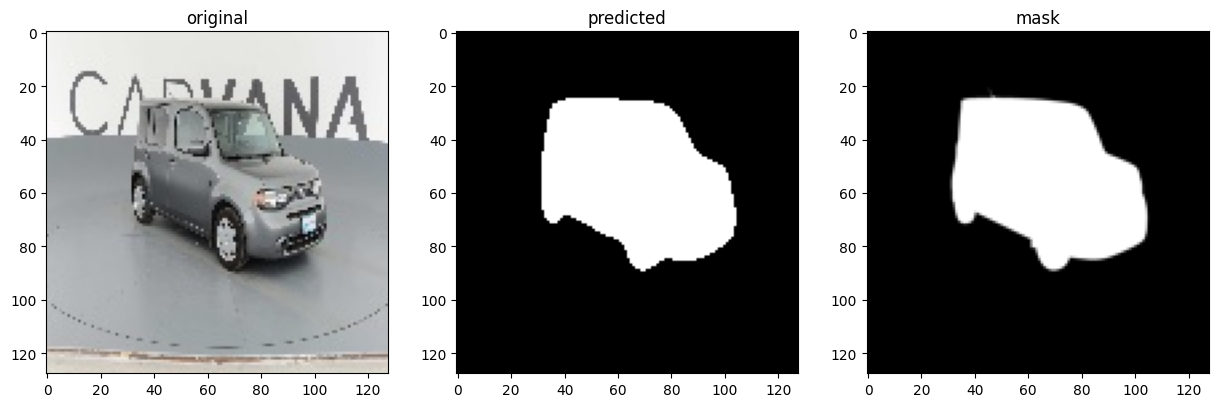

Image: 293a0fa72e5b_13.jpg, DICE coefficient: 0.9844


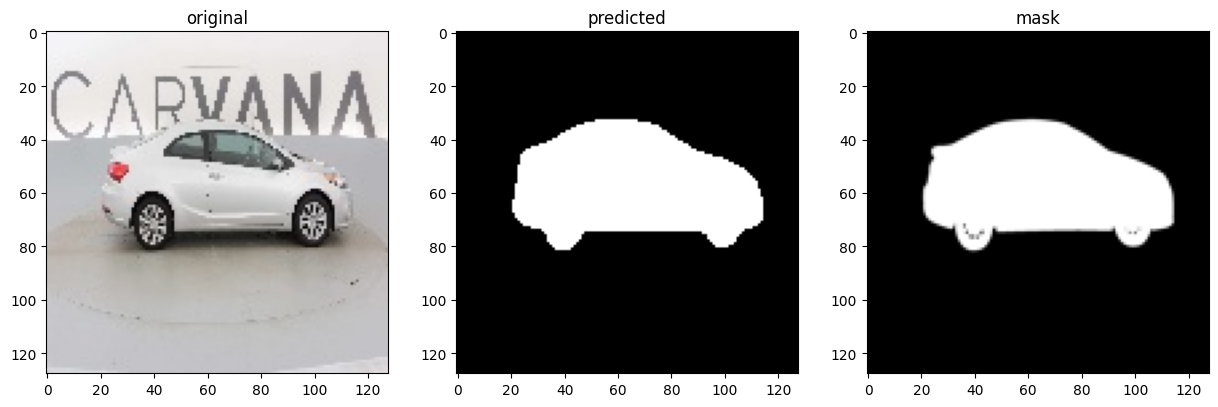

Image: 4e7bc95552ed_13.jpg, DICE coefficient: 0.98553


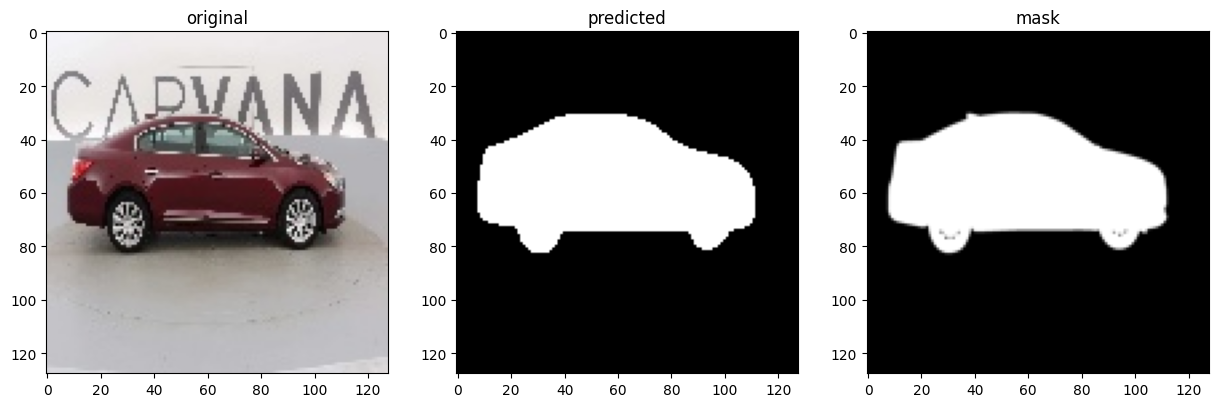

Image: 2c57132da7a0_02.jpg, DICE coefficient: 0.98073


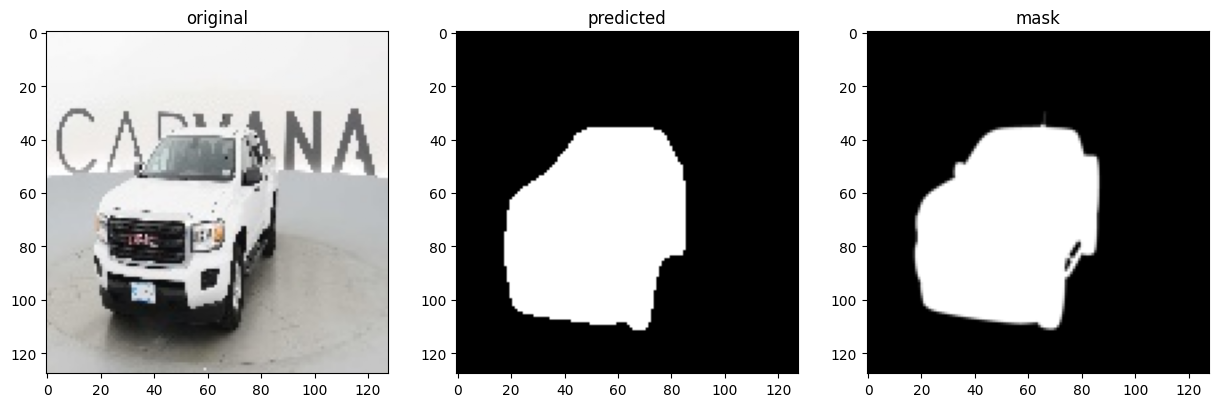

Image: 364923a5002f_04.jpg, DICE coefficient: 0.98131


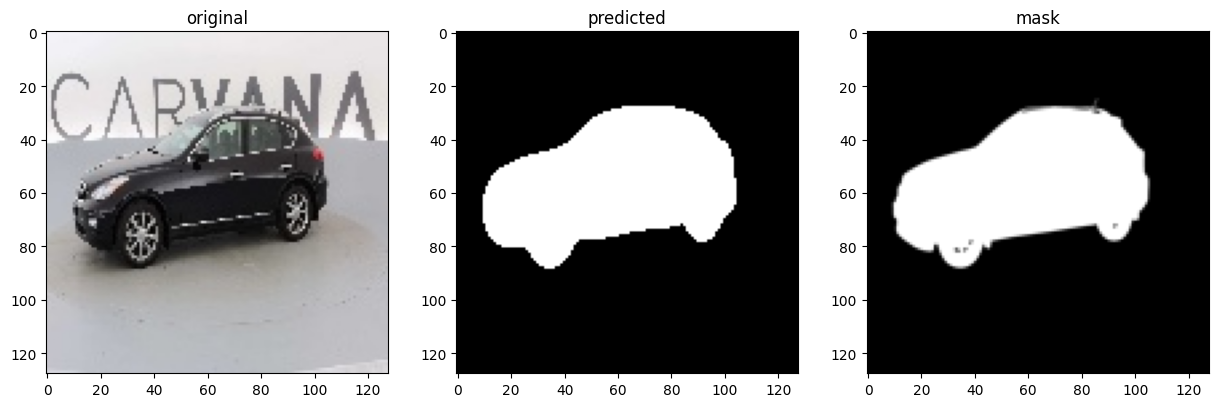

In [43]:
model_path = out_checkpoint

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")

/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_59695/3993457196.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, m

Image: 304437bad7ff_15.jpg, DICE coefficient: 0.9851


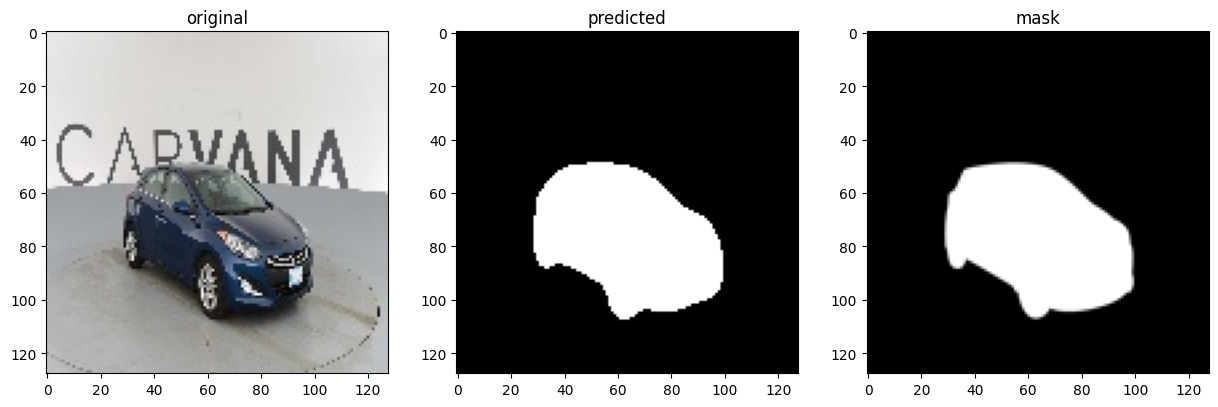

Image: 28109f18d9d4_05.jpg, DICE coefficient: 0.98089


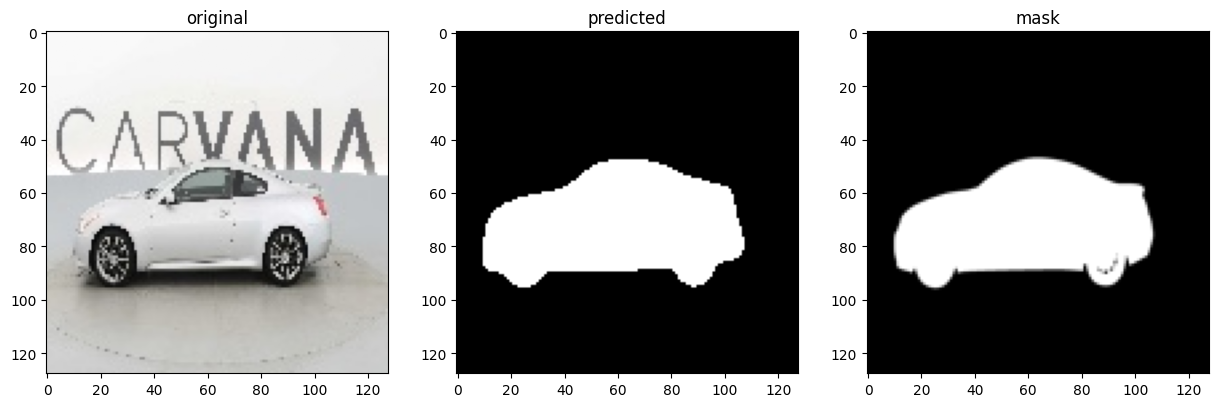

Image: 3afec4b5ac07_11.jpg, DICE coefficient: 0.98487


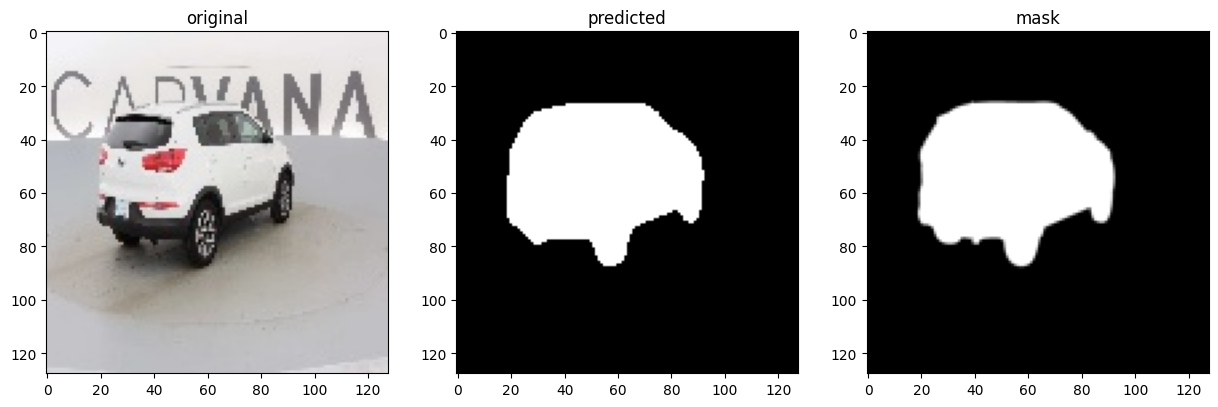

Image: 1adaeb44f109_04.jpg, DICE coefficient: 0.98348


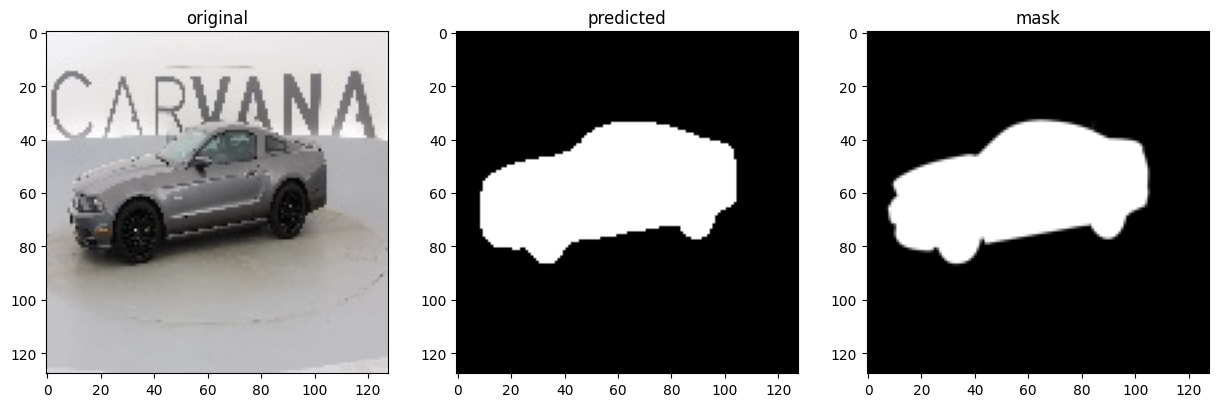

Image: 08a646be6b30_01.jpg, DICE coefficient: 0.97126


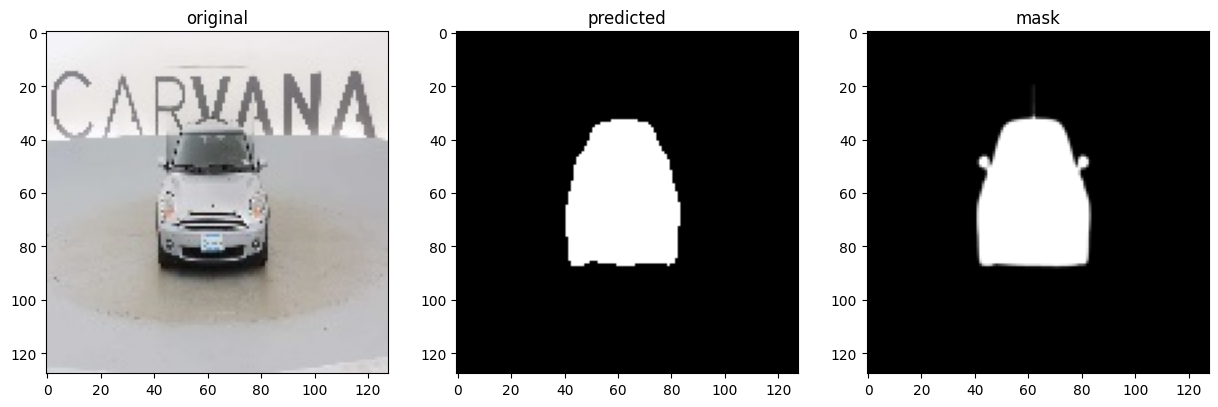

Image: 4f0397cf7937_03.jpg, DICE coefficient: 0.98283


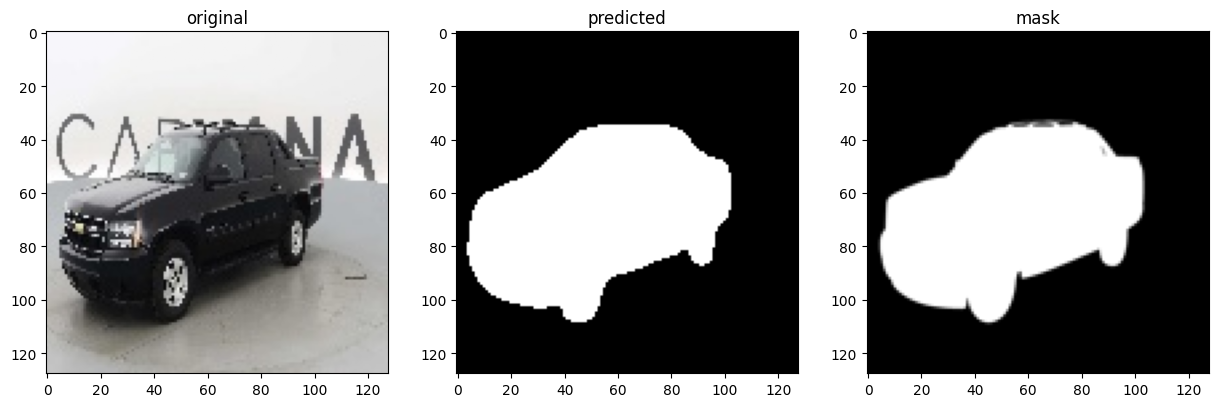

Image: 1b25ea8ba94d_03.jpg, DICE coefficient: 0.98425


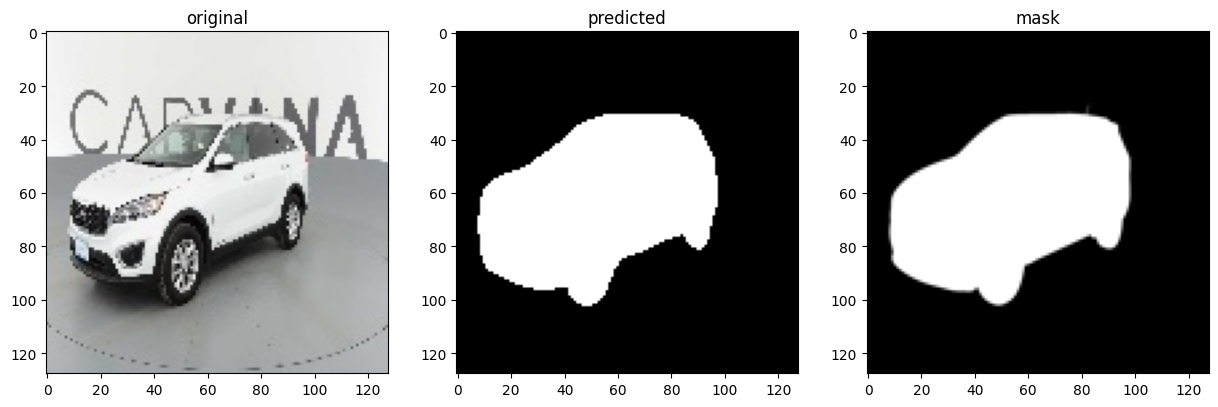

Image: 371f057d1242_10.jpg, DICE coefficient: 0.98398


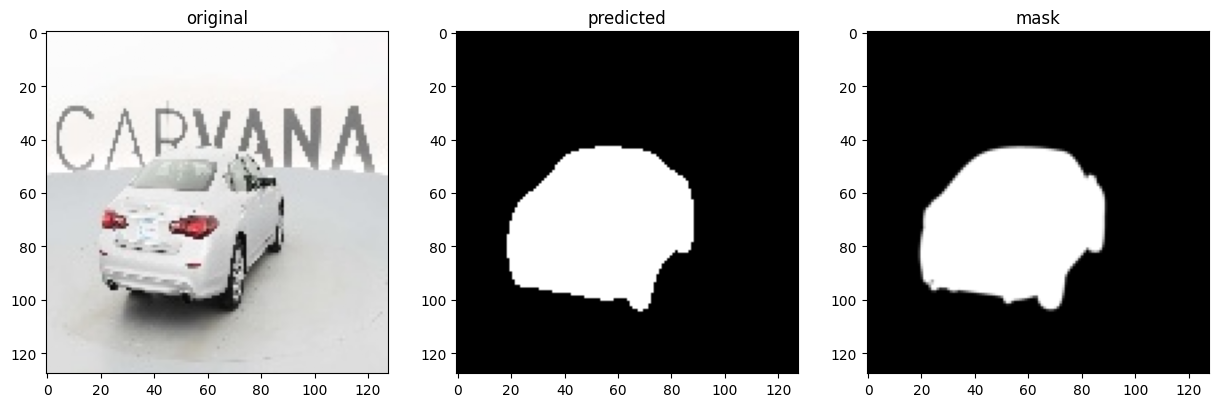

Image: 4e5ac4b9f074_11.jpg, DICE coefficient: 0.98022


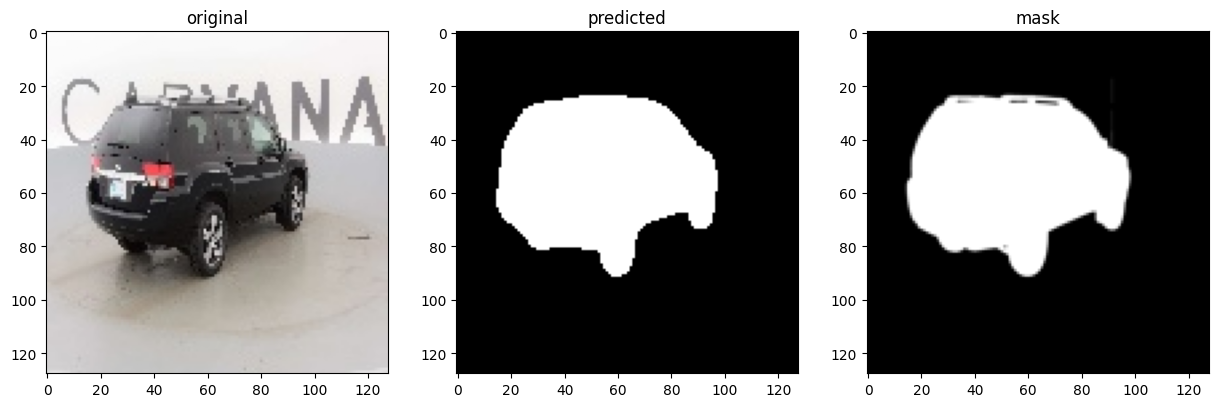

Image: 0eeaf1ff136d_14.jpg, DICE coefficient: 0.98318


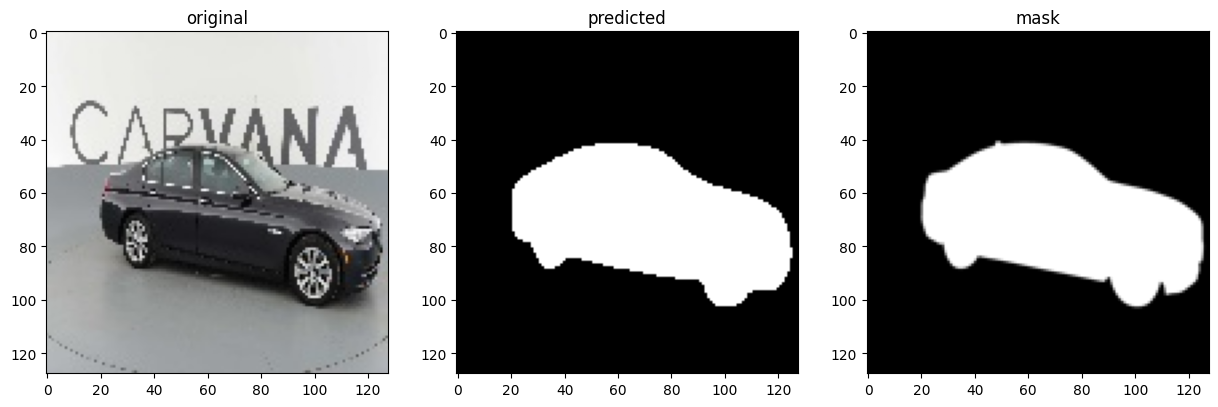

In [44]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")

Image: 316bbfd3d93d_05.jpg, DICE coefficient: 0.97613


/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_59695/3993457196.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, m

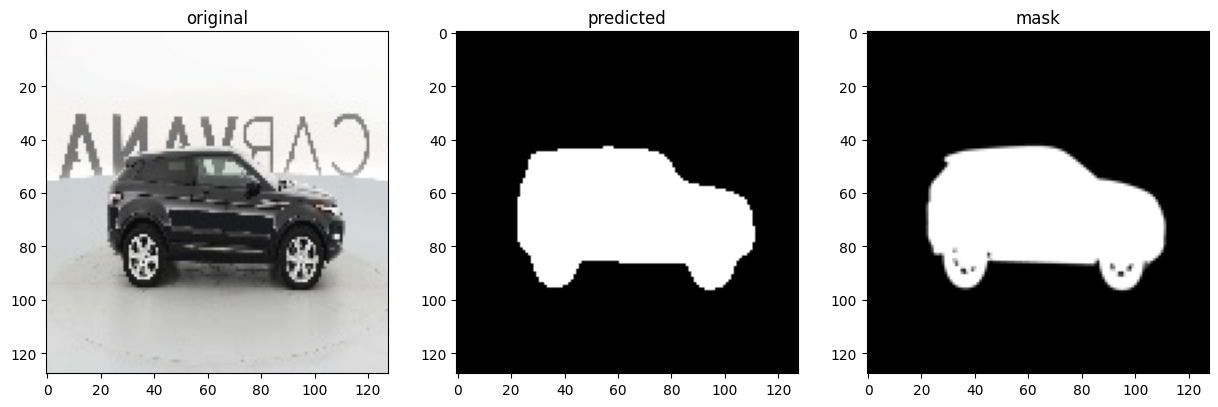

Image: 2f39abb12388_13.jpg, DICE coefficient: 0.97692


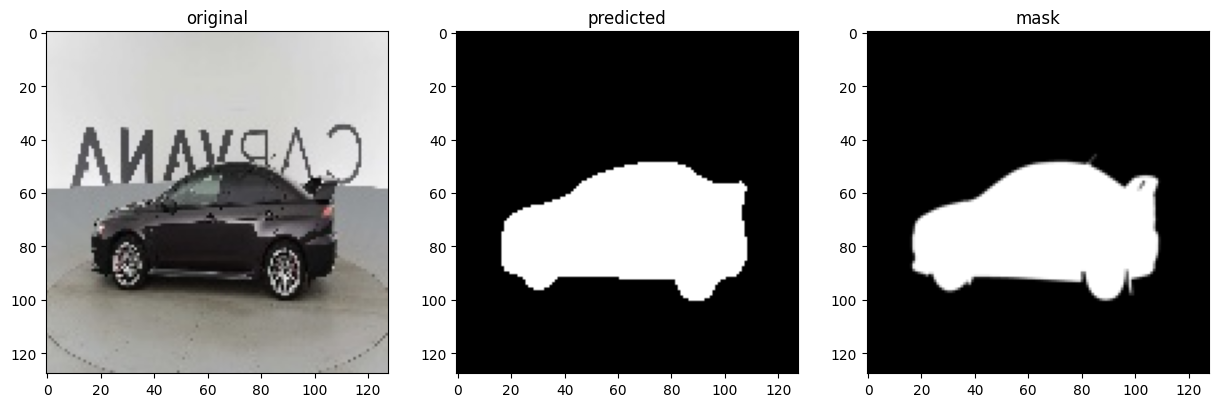

Image: 47ea8f25c948_06.jpg, DICE coefficient: 0.98078


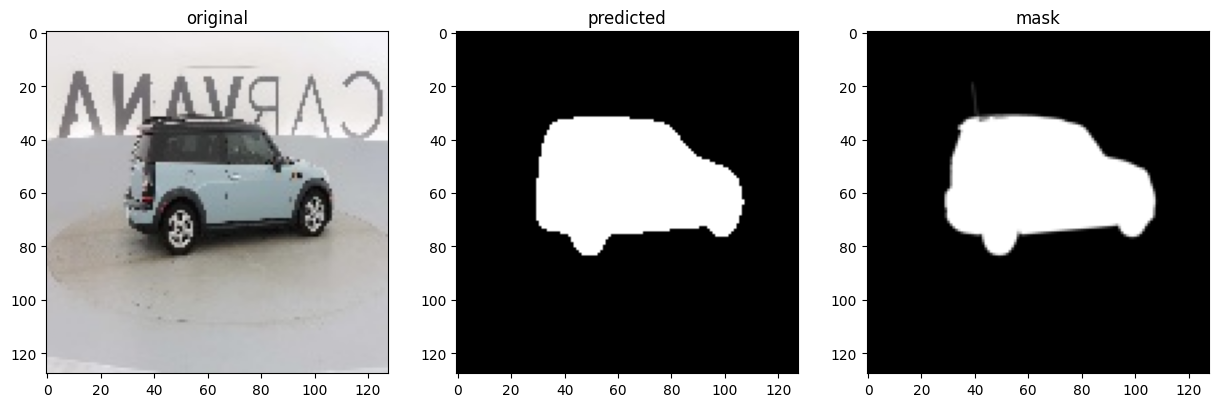

Image: 0d1a9caf4350_14.jpg, DICE coefficient: 0.97536


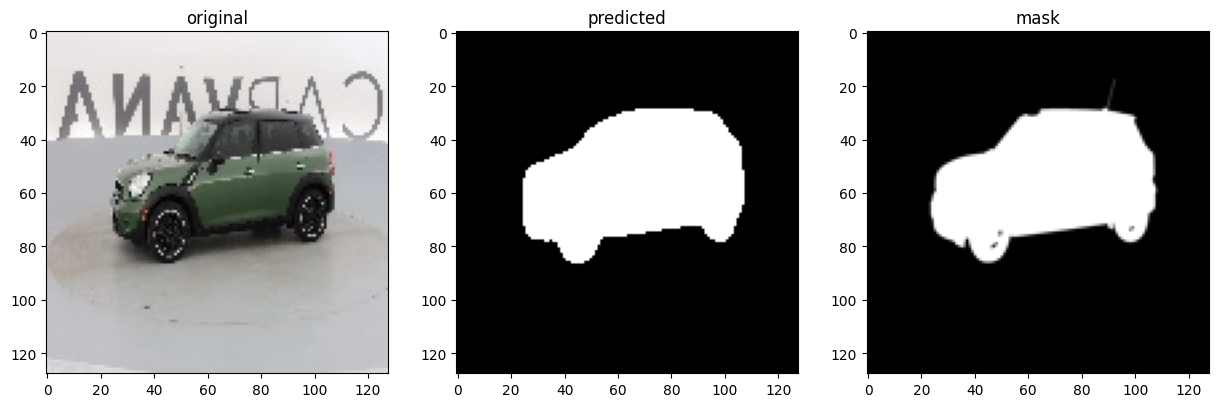

Image: 304437bad7ff_13.jpg, DICE coefficient: 0.98179


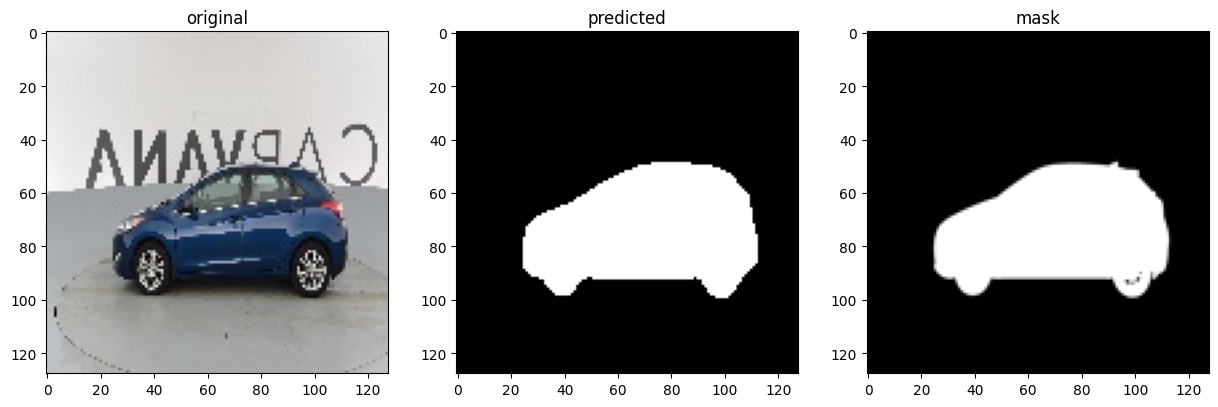

Image: 4baf50a3d8c2_02.jpg, DICE coefficient: 0.97799


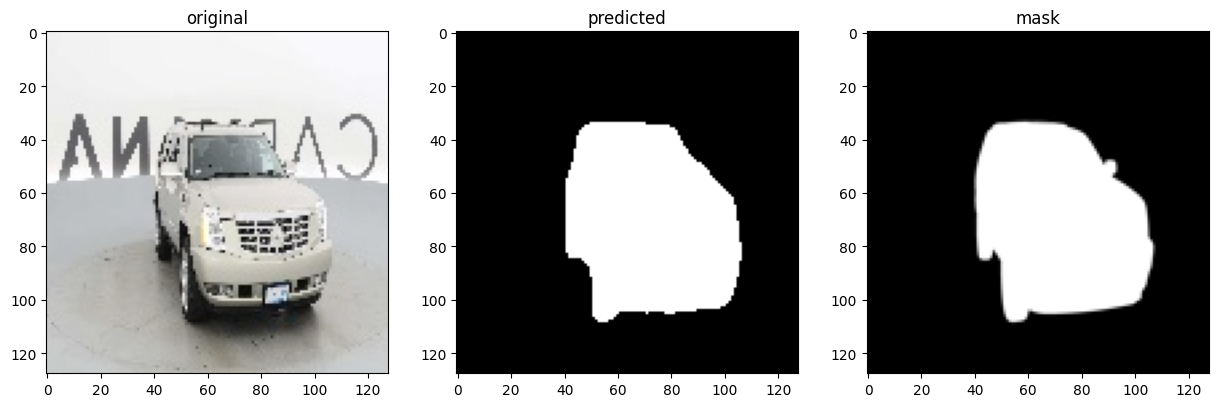

Image: 1a17a1bd648b_13.jpg, DICE coefficient: 0.97994


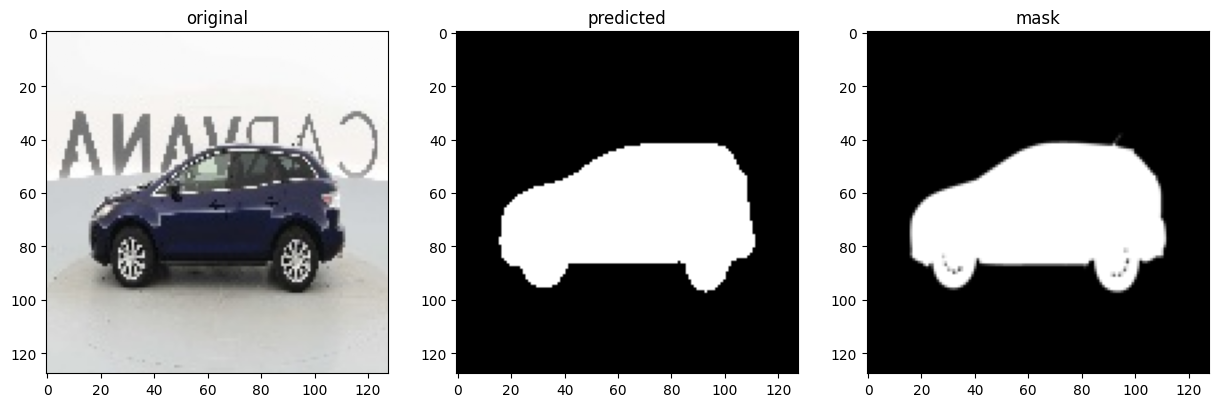

Image: 56023a17481b_04.jpg, DICE coefficient: 0.97059


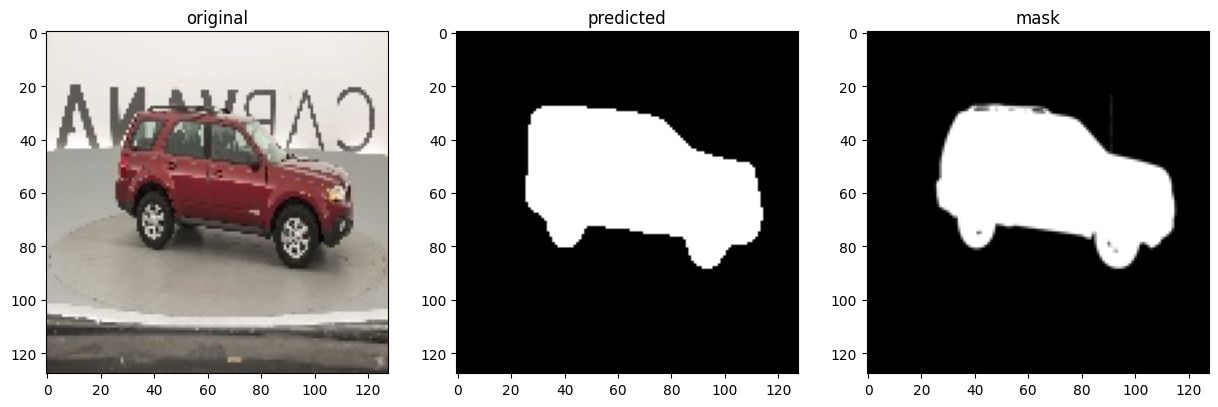

Image: 08a646be6b30_05.jpg, DICE coefficient: 0.97577


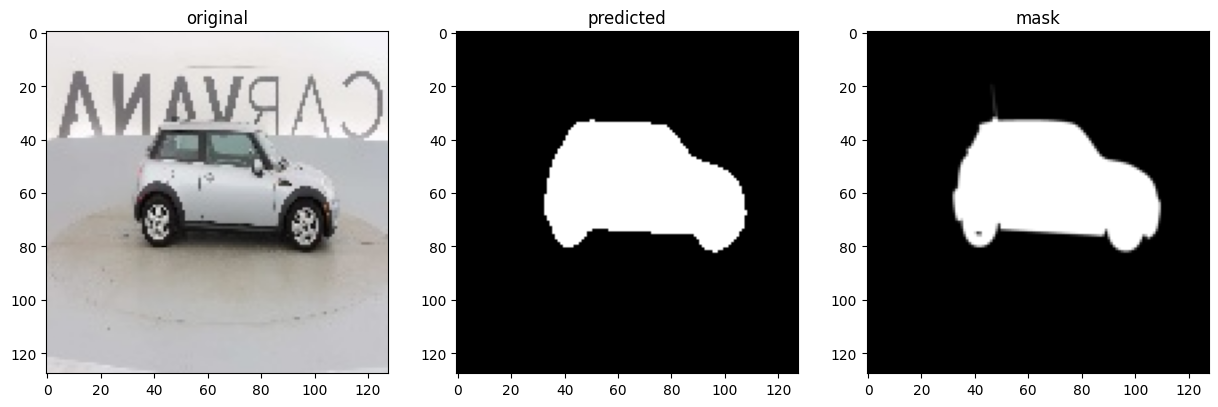

Image: 1ae8a68a40e4_15.jpg, DICE coefficient: 0.98255


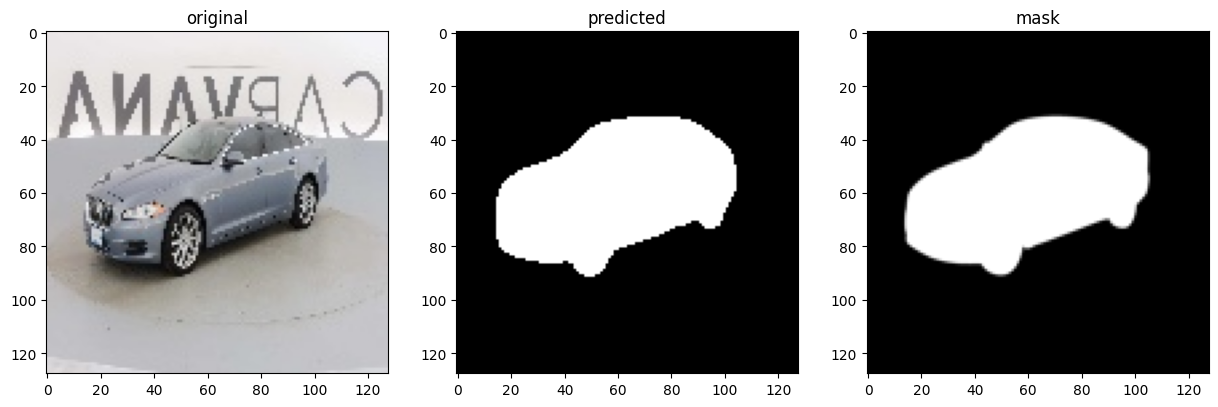

In [45]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu", flip=True)